# Scikit-image testbench for image classification

## First steps: import and show an image with scikit-image


In [52]:
%matplotlib inline


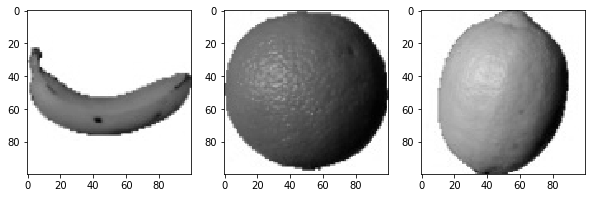

In [53]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt

# path to fruit360 dataset
path = '/home/gino/Desktop/fruits-360_dataset/'

def img_grayscale(image):
    return io.imread(image, as_gray=True)

banana_collection = io.ImageCollection([path + 'fruits-360/Training/Banana/*.jpg', path + 'fruits-360/Training/Banana Lady Finger/*.jpg'], load_func=img_grayscale)
orange_collection = io.ImageCollection(path + 'fruits-360/Training/Orange/*.jpg', load_func=img_grayscale)
lemon_collection = io.ImageCollection(path + 'fruits-360/Training/Lemon/*.jpg', load_func=img_grayscale)

fig, (ban, oran, lem) = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

sample_banana = banana_collection[380]
ban.imshow(sample_banana, cmap='gray')
oran.imshow(orange_collection[0], cmap='gray')
lem.imshow(lemon_collection[1], cmap='gray')


#print(banana_collection)

## Filtering

In [54]:
from skimage import filters

### Gaussian filter

(100, 100)
float64


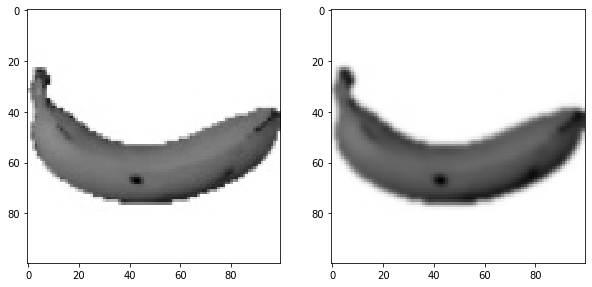

In [55]:

gauss_filtered = filters.gaussian(sample_banana, sigma=1)

print(gauss_filtered.shape)
print(sample_banana.dtype)

fig, ax = plt.subplots(1, 2)

ax[0].imshow(sample_banana, cmap='gray')
ax[1].imshow(gauss_filtered, cmap='gray')

fig.set_size_inches(10, 10)

### Edge detection: Sobel and Scharr filters

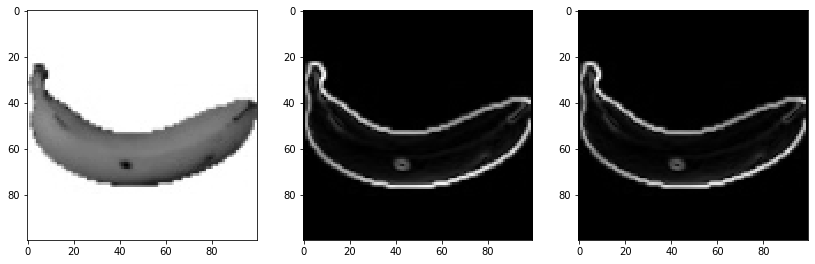

In [56]:
sobel_filtered = filters.sobel(sample_banana)

#plt.imshow(sample_banana, cmap='gray')

scharr_filtered = filters.scharr(sample_banana)

fig, ax = plt.subplots(1, 3)

ax[0].imshow(sample_banana, cmap='gray')
ax[1].imshow(sobel_filtered, cmap='gray')
ax[2].imshow(scharr_filtered, cmap='gray')


fig.set_size_inches(14, 14)

#plt.imshow(scharr_filtered - sobel_filtered, cmap='gray')

### More edge detection: Canny filter

The Canny filter is a multi-stage edge detector. It uses a filter based on the derivative of a Gaussian in order to compute the intensity of the gradients.The Gaussian reduces the effect of noise present in the image. Then, potential edges are thinned down to 1-pixel curves by removing non-maximum pixels of the gradient magnitude. Finally, edge pixels are kept or removed using hysteresis thresholding on the gradient magnitude.

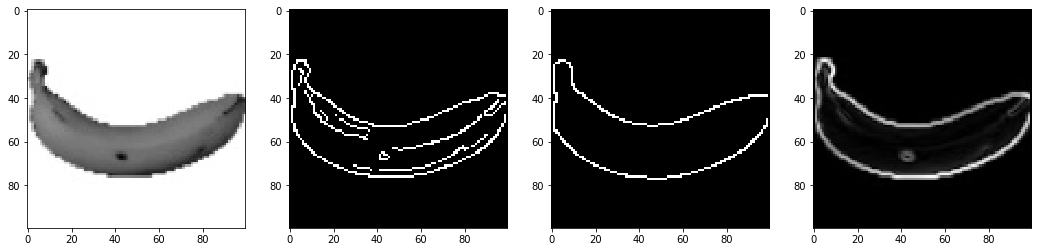

In [57]:
from skimage import feature
import matplotlib.pyplot as plt

canny_filtered_lowsigma = feature.canny(sample_banana, sigma=.5)
canny_filtered_hisigma = feature.canny(sample_banana, sigma=3)


fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))

ax[0].imshow(sample_banana, cmap='gray')
ax[1].imshow(canny_filtered_lowsigma, cmap='gray')
ax[2].imshow(canny_filtered_hisigma, cmap='gray')
#ax[3].imshow(canny_filtered_pregaussian, cmap='gray')
ax[3].imshow(sobel_filtered, cmap='gray')

### Thresholding

Many techniques exist but given the quality of the dataset we will not require any fancy thresholding algorithms or methods as hystheresis thresholing. The latter is used in the Canny edge-detection filter.  

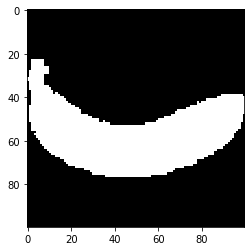

In [58]:
# Threshold value. Can be obtained algorithmically
threshold = .9

thresholded_banana = sample_banana < threshold

plt.imshow(thresholded_banana, cmap='gray')

### Trying all thresholding methods

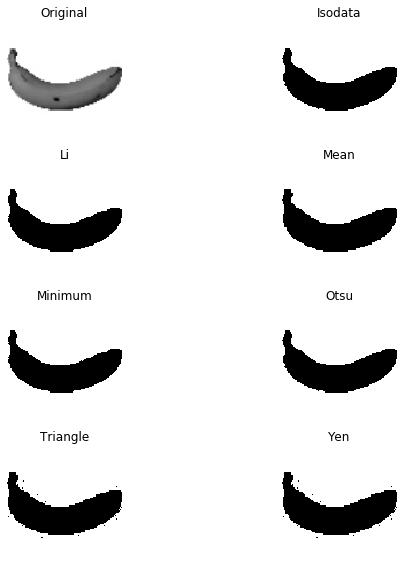

In [59]:
fig, ax = filters.try_all_threshold(sample_banana, figsize=(10, 8), verbose=False)
plt.show()

## Feature extraction

### Moments and inertia tensor I

After preprocessing the images we need to find a feature which can be expressed as a number to identify each fruit. Since foreground has been separated from background we can find the moments of the resulting shape. This can be done with either the grayscale image or the binary one. Even though the grayscale version has informatino about the texture of the fruit we'll focus by now on binary images because these lack noise from lighting sources, from example, which can affect measurements. 

[[2.56600000e+03 1.20494000e+05 7.74945200e+06 5.63875880e+08]
 [1.45078000e+05 6.92243800e+06 4.36063936e+08 3.10180615e+10]
 [8.49801600e+06 4.08220852e+08 2.51914994e+10 1.75219568e+12]
 [5.12318164e+08 2.46535345e+10 1.49178918e+12 1.01531702e+14]]

Area: 2566.0

Centroid (row, column): (56.538581449727204, 46.95791114575214)


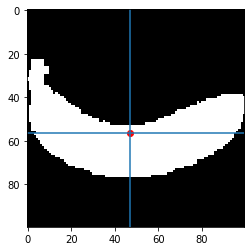

In [60]:
from skimage import measure

M = measure.moments(thresholded_banana)
print(M)
print("\nArea:", M[0, 0])

centroid = (M[1, 0] / M[0, 0], M[0, 1] / M[0, 0]) 
print("\nCentroid (row, column):", centroid)

fig, ax = plt.subplots(ncols=1, nrows=1)

ax.imshow(thresholded_banana, cmap='gray')
ax.axhline(centroid[0])
ax.axvline(centroid[1])

ax.scatter(x=centroid[1], y=centroid[0], color='r')


In [61]:
# Moments

central_moments = measure.moments_central(thresholded_banana, center=centroid)

print("Centroidal moments:\n", central_moments)

normalized_central_moments = measure.moments_normalized(central_moments)

print("\nNormalized centroidal moments:\n", normalized_central_moments)


Centroidal moments:
 [[ 2.56600000e+03  2.33058017e-12  2.09130545e+06  3.57113014e+06]
 [ 3.01270120e-12  1.09878167e+05 -1.23983855e+07  1.57066931e+08]
 [ 2.95511680e+05 -3.25293961e+06  3.08497503e+08 -5.28587518e+09]
 [-1.56322820e+06  9.41800923e+07 -5.27607477e+09  1.61546567e+11]]

Normalized centroidal moments:
 [[        nan         nan  0.31761731  0.01070691]
 [        nan  0.01668776 -0.03717265  0.0092964 ]
 [ 0.04488088 -0.00975291  0.0182592  -0.00617616]
 [-0.00468685  0.00557428 -0.00616471  0.00372624]]


In [62]:
hu_moments = measure.moments_hu(normalized_central_moments)
print("Hu moments:\n", hu_moments)

inertia_tensor = measure.inertia_tensor(thresholded_banana, mu=central_moments)
print("Inertia Tensor:\n", inertia_tensor)


Hu moments:
 [ 3.62498190e-01  7.54990879e-02  1.30101367e-02  1.75312744e-03
 -8.02390940e-06 -4.80310906e-04  2.39114469e-06]
Inertia Tensor:
 [[815.00602276 -42.82079766]
 [-42.82079766 115.16433376]]


The eigenvalues of the inertia tensor are the __principal moments of inertia__. The corresponding eigenvectors correspond to the __principal axis of inertia__.

In [63]:
inertia_eigvalues = measure.inertia_tensor_eigvals(thresholded_banana, T=inertia_tensor)
print(inertia_eigvalues)

[817.6163373485363, 112.55401917532119]


In [64]:
# Principal moments ratio

ratio = max(inertia_eigvalues)/min(inertia_eigvalues)

if len(inertia_eigvalues) == 2:
    print("Principal moments ratio: ", ratio)
else:
    print("Fail")


Principal moments ratio:  7.264212716162236


### Moments and inertia tensor II. Comparison between shape, contour and textured.

[[2.95000000e+02 1.26810000e+04 8.53995000e+05 6.52857270e+07]
 [1.58110000e+04 7.17648000e+05 4.76916900e+07 3.58450181e+09]
 [9.14613000e+05 4.27812640e+07 2.79469685e+09 2.06156535e+11]
 [5.61775930e+07 2.66855075e+09 1.71016378e+11 1.23665871e+13]]

Area: 295.0

Centroid (row, column): (53.59661016949153, 42.9864406779661)


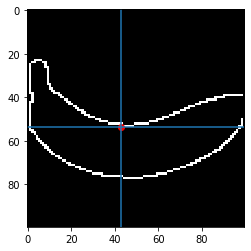

In [65]:
M = measure.moments(canny_filtered_hisigma)

print(M)
print("\nArea:", M[0, 0])

centroid = (M[1, 0] / M[0, 0], M[0, 1] / M[0, 0]) 
print("\nCentroid (row, column):", centroid)

fig, ax = plt.subplots(ncols=1, nrows=1)

ax.imshow(canny_filtered_hisigma, cmap='gray')
ax.axhline(centroid[0])
ax.axvline(centroid[1])

ax.scatter(x=centroid[1], y=centroid[0], color='r')


In [66]:
# Moments

central_moments = measure.moments_central(thresholded_banana, center=centroid)

print("Centroidal moments:\n", central_moments)

normalized_central_moments = measure.moments_normalized(central_moments)

print("\nNormalized centroidal moments:\n", normalized_central_moments)

hu_moments = measure.moments_hu(normalized_central_moments)
print("Hu moments:\n", hu_moments)

inertia_tensor = measure.inertia_tensor(thresholded_banana, mu=central_moments)
print("Inertia Tensor:\n", inertia_tensor)

inertia_eigvalues = measure.inertia_tensor_eigvals(thresholded_banana, T=inertia_tensor)
print(inertia_eigvalues)

# Principal moments ratio

ratio = max(inertia_eigvalues)/min(inertia_eigvalues)

if len(inertia_eigvalues) == 2:
    print("Principal moments ratio: ", ratio)
else:
    print("Fail")


Centroidal moments:
 [[ 2.56600000e+03  1.01907932e+04  2.13177789e+06  2.86485388e+07]
 [ 7.54909831e+03  1.39859188e+05 -5.25400037e+06  9.88298298e+07]
 [ 3.17720911e+05 -1.34460357e+06  2.37955387e+08 -1.41216944e+09]
 [ 1.11027134e+06  7.27323883e+07 -2.26178488e+09  8.87433365e+10]]

Normalized centroidal moments:
 [[        nan         nan  0.32376407  0.08589361]
 [        nan  0.02124113 -0.01575246  0.00584949]
 [ 0.04825391 -0.00403137  0.01408399 -0.00165002]
 [ 0.0033288   0.00430485 -0.00264273  0.00204696]]
Hu moments:
 [3.72017977e-01 7.77105916e-02 1.21605551e-02 6.85577348e-03
 6.25790062e-05 1.71737528e-03 1.54738378e-06]
Inertia Tensor:
 [[830.77860044 -54.50474972]
 [-54.50474972 123.81952878]]
[834.9560930467846, 119.64203616730094]
Principal moments ratio:  6.978785381746824


[[1.27298948e+03 6.16389776e+04 4.01803078e+06 2.95275909e+08]
 [7.24471037e+04 3.55963902e+06 2.27186153e+08 1.63105077e+10]
 [4.27428023e+06 2.11151457e+08 1.31973085e+10 9.25939846e+11]
 [2.59618403e+08 1.28320646e+10 7.86192728e+11 5.39487657e+13]]

Area: 1272.9894764705882

Centroid (row, column): (56.910999691843166, 48.42064977685467)


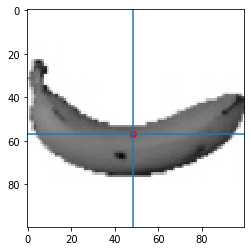

In [67]:
# Use negative image. White is 1 and black is 0
M = measure.moments( 1 - sample_banana)

print(M)
print("\nArea:", M[0, 0])

centroid = (M[1, 0] / M[0, 0], M[0, 1] / M[0, 0]) 
print("\nCentroid (row, column):", centroid)

fig, ax = plt.subplots(ncols=1, nrows=1)

ax.imshow(sample_banana, cmap='gray')
ax.axhline(centroid[0])
ax.axvline(centroid[1])

ax.scatter(x=centroid[1], y=centroid[0], color='r')


In [68]:
# Moments

central_moments = measure.moments_central(thresholded_banana, center=centroid)

print("Centroidal moments:\n", central_moments)

normalized_central_moments = measure.moments_normalized(central_moments)

print("\nNormalized centroidal moments:\n", normalized_central_moments)

hu_moments = measure.moments_hu(normalized_central_moments)
print("Hu moments:\n", hu_moments)

inertia_tensor = measure.inertia_tensor(thresholded_banana, mu=central_moments)
print("Inertia Tensor:\n", inertia_tensor)

inertia_eigvalues = measure.inertia_tensor_eigvals(thresholded_banana, T=inertia_tensor)
print(inertia_eigvalues)

# Principal moments ratio

ratio = max(inertia_eigvalues)/min(inertia_eigvalues)

if len(inertia_eigvalues) == 2:
    print("Principal moments ratio: ", ratio)
else:
    print("Fail")


Centroidal moments:
 [[ 2.56600000e+03 -3.75338733e+03  2.09679568e+06 -5.61400045e+06]
 [-9.55625209e+02  1.11275997e+05 -1.35007165e+07  2.14269767e+08]
 [ 2.95867573e+05 -3.76755780e+06  3.28411192e+08 -6.82025100e+09]
 [-1.89352257e+06  1.00629902e+08 -5.91635098e+09  1.92839632e+11]]

Normalized centroidal moments:
 [[        nan         nan  0.31845114 -0.01683181]
 [        nan  0.01690006 -0.04047764  0.01268209]
 [ 0.04493493 -0.01129583  0.01943784 -0.00796897]
 [-0.00567713  0.00595603 -0.00691283  0.00444805]]
Hu moments:
 [ 3.63386070e-01  7.59535656e-02  1.36902998e-02  2.92142718e-03
  3.98584496e-06 -2.78504848e-04  1.80405561e-05]
Inertia Tensor:
 [[817.14562706 -43.36554821]
 [-43.36554821 115.30302911]]
[819.8149513322135, 112.6337048416247]
Principal moments ratio:  7.278593494593496


## Feature comparison

### Between bananas, oranges and lemons

We'll measure the principal moments ratio for all the fruit pictures in the respective training dataset.

In [69]:
banana_size = len(banana_collection)
orange_size = len(orange_collection)
lemon_size = len(lemon_collection)


threshold = 0.9

banana_hu_moments = np.zeros((banana_size, 7))
banana_moment_ratio = np.zeros((banana_size, 1))
banana_eigvalues = np.zeros((banana_size, 2))


for i, image in enumerate(banana_collection):
    
    current_fruit = banana_collection[i]
    
    thresholded_fruit = current_fruit < threshold
    fruit_central_moments = measure.moments_central(thresholded_fruit)
    
    banana_hu_moments[i, :] = measure.moments_hu(measure.moments_normalized(fruit_central_moments))
    banana_eigvalues[i, :] = measure.inertia_tensor_eigvals(thresholded_fruit, mu=fruit_central_moments)
    
    banana_moment_ratio[i, 0] = max(banana_eigvalues[i, :])/min(banana_eigvalues[i, :])
    

In [70]:
orange_hu_moments = np.zeros((orange_size, 7))
orange_moment_ratio = np.zeros((orange_size, 1))
orange_eigvalues = np.zeros((orange_size, 2))

for i, image in enumerate(orange_collection):
    
    current_fruit = orange_collection[i]
    
    thresholded_fruit = current_fruit < threshold
    fruit_central_moments = measure.moments_central(thresholded_fruit)
    
    orange_hu_moments[i, :] = measure.moments_hu(measure.moments_normalized(fruit_central_moments))
    orange_eigvalues[i, :] = measure.inertia_tensor_eigvals(thresholded_fruit, mu=fruit_central_moments)
    
    orange_moment_ratio[i, 0] = max(orange_eigvalues[i, :])/min(orange_eigvalues[i, :])


In [71]:
lemon_hu_moments = np.zeros((lemon_size, 7))
lemon_moment_ratio = np.zeros((lemon_size, 1))
lemon_eigvalues = np.zeros((lemon_size, 2))

for i, image in enumerate(lemon_collection):
    
    current_fruit = lemon_collection[i]
    
    thresholded_fruit = current_fruit < threshold
    fruit_central_moments = measure.moments_central(thresholded_fruit)
    
    lemon_hu_moments[i, :] = measure.moments_hu(measure.moments_normalized(fruit_central_moments))
    lemon_eigvalues[i, :] = measure.inertia_tensor_eigvals(thresholded_fruit, mu=fruit_central_moments)
    
    lemon_moment_ratio[i, 0] = max(lemon_eigvalues[i, :])/min(lemon_eigvalues[i, :])


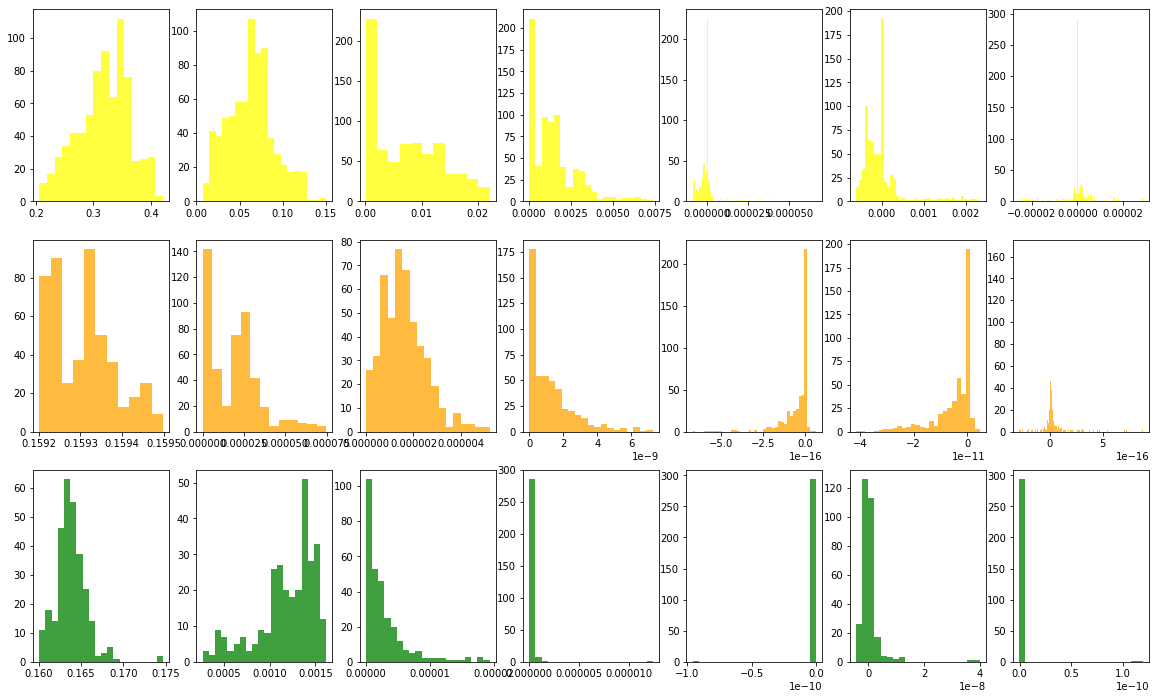

In [82]:
fig, ax = plt.subplots(nrows=3, ncols=7, figsize=(20, 12))

for i in range(0, 7):

    ax[0, i].hist(banana_hu_moments[:, i], bins='auto', color='yellow', alpha=0.75)
    ax[1, i].hist(orange_hu_moments[:, i], bins='auto', color='orange', alpha=0.75)
    ax[2, i].hist(lemon_hu_moments[:, i], bins=20, color='green', alpha=0.75)
    
    #ax[1, i].hist(banana_hu_moments[:, i], bins='auto', color='green', cumulative='True')

plt.show()

Mean:  8.946227028585747
Std. dev:  4.200427908868824 

Mean:  1.0505666289117186
Std. dev:  0.02601386457821182 

Mean:  1.5275417987478148
Std. dev:  0.09065204871059523 



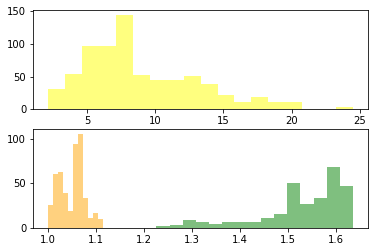

In [85]:
fig, ax = plt.subplots(nrows=2, ncols=1)

ax[0].hist(banana_moment_ratio, bins='auto', color='yellow', alpha=.5)
ax[1].hist(orange_moment_ratio, bins='auto', color='orange', alpha=.5)
ax[1].hist(lemon_moment_ratio, bins='auto', color='green', alpha=.5)

print("Mean: ", np.mean(banana_moment_ratio))
print("Std. dev: ", np.std(banana_moment_ratio), "\n")

print("Mean: ", np.mean(orange_moment_ratio))
print("Std. dev: ", np.std(orange_moment_ratio), "\n")

print("Mean: ", np.mean(lemon_moment_ratio))
print("Std. dev: ", np.std(lemon_moment_ratio), "\n")

(0, 670.9542355245216)

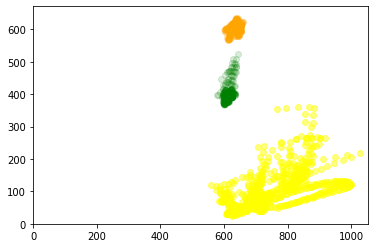

In [80]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.scatter(x=banana_eigvalues[:, 0], y=banana_eigvalues[:, 1], c='yellow', alpha=.5)
ax.scatter(x=orange_eigvalues[:, 0], y=orange_eigvalues[:, 1], c='orange', alpha=.15)
ax.scatter(x=lemon_eigvalues[:, 0], y=lemon_eigvalues[:, 1], c='green', alpha=.15)

ax.set_xlim(left=0)
ax.set_ylim(bottom=0)


(0, 25.682664330176273)

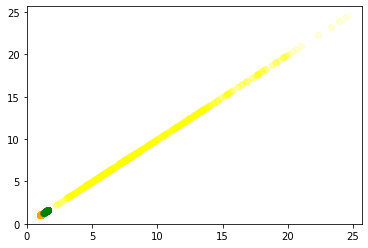

In [90]:
fig, ax = plt.subplots(nrows=1, ncols=1)

ax.scatter(x=banana_moment_ratio[:], y=banana_moment_ratio[:], c='yellow', alpha=.15)
ax.scatter(x=orange_moment_ratio[:], y=orange_moment_ratio[:], c='orange', alpha=.15)
ax.scatter(x=lemon_moment_ratio[:], y=lemon_moment_ratio[:], c='green', alpha=.15)

ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
